In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import pickle
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from sympy.physics.wigner import wigner_3j, wigner_6j

sys.path.append('./molecular-state-classes-and-functions/')
from classes import UncoupledBasisState, CoupledBasisState, State

In [3]:
from functions import find_state_idx_from_state, make_transform_matrix
from functions import make_hamiltonian, make_hamiltonian_B, make_QN, ni_range, vector_to_state, matrix_to_states
from state_functions import find_exact_states, calculate_BR
from hamiltonian_functions import reduced_basis_hamiltonian
from laser_functions import optical_coupling_matrix, ED_ME_mixed_state, calculate_power_needed, laser_field
from collapse_functions import collapse_matrices
from density_functions import generate_density_matrix

## X State Hamiltonian

In [4]:
H_X_uc = make_hamiltonian("./stored_data/TlF_X_state_hamiltonian_J0to4.pickle")

In [5]:
Jmin = 0
Jmax = 4
I_F = 1/2
I_Tl = 1/2
QN_X = [CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
      for J  in ni_range(Jmin, Jmax+1)
      for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
      for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
      for mF in ni_range(-F, F+1)
     ]

In [6]:
### Transform Hamiltonian to coupled basis ###
#Load transform matrix
with open("./stored_data/UC_to_C_j0to4.pickle","rb") as f:
    S_trans = pickle.load(f)

In [7]:
#Transform matrix
E = np.array((0,0,0))
B = np.array((0,0,0.001))
H_X =  S_trans.conj().T @ H_X_uc(E, B) @ S_trans

In [8]:
D, V = np.linalg.eigh(H_X)

# Diagonalize the Hamiltonian
H_X_diag = V.conj().T @ H_X @ V

# Remove very small entries from V
# V[np.abs(V) < 1e-5] = 0

# New set of quantum numbers:
QN_X_diag = matrix_to_states(V, QN_X)

state = vector_to_state(V[:,1],QN_X)
state.print_state()

+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>


In [9]:
# Define what states are to be included in the simulation
Js_g = [0,1,2]
ground_states_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                  for J  in Js_g
                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                  for mF in ni_range(-F, F+1)
                 ]

ground_states = find_exact_states(ground_states_approx, H_X_diag, QN_X_diag)

In [10]:
H_X_red = reduced_basis_hamiltonian(QN_X_diag, H_X_diag, ground_states)

# Set small off diagonal terms to zero
H_X_red[np.abs(H_X_red) < 0.1] = 0

## B State Hamiltonian

In [11]:
H_B = make_hamiltonian_B("./stored_data/B_hamiltonians_symbolic_coupled_P_1to3.pickle")

In [12]:
Jmin = 1
Jmax = 3
I_F = 1/2
I_Tl = 1/2
Ps = [-1, 1]
QN_B = [CoupledBasisState(F,mF,F1,J,I_F,I_Tl,P = P, Omega = 1, electronic_state='B')
      for J  in ni_range(Jmin, Jmax+1)
      for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
      for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
      for mF in ni_range(-F, F+1)
      for P in Ps
     ]

In [13]:
D,V = np.linalg.eigh(H_B)

# Diagonalize the Hamiltonian
H_B_diag = V.conj().T @ H_B @ V

# New set of quantum numbers:
QN_B_diag = matrix_to_states(V, QN_B)

state = vector_to_state(V[:,1],QN_B)
state.print_state()

+1.0000+0.0000j x |B, J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>


In [14]:
# Define what states are to be included in the simulation
J = 1
F1 = 3/2
F = 1
excited_states_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='B', P = -1, Omega = 1)
                  for mF in ni_range(-F, F+1)
                 ]

excited_states = find_exact_states(excited_states_approx, H_B_diag, QN_B_diag)

In [15]:
H_B_red = reduced_basis_hamiltonian(QN_B_diag, H_B_diag, excited_states)

## Optical Couplings
Generating the matrix of optical couplings here. Assuming rotating frame so no $\exp(i\omega t)$ time-dependence

In [16]:
# Define QN for the total Hamiltonian that includes both X and B
QN = ground_states + excited_states

# Define ground states for laser driven transition
Js = [2]
ground_states_laser_approx =  [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                                  for J  in Js
                                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                                  for mF in ni_range(-F, F+1)
                                 ]

ground_states_laser = find_exact_states(ground_states_laser_approx, H_X_diag, QN_X_diag)

#Excited states for laser
excited_states_laser = excited_states

In [17]:
%%time
# Coupling laser for z-polarized
H_laser_z = optical_coupling_matrix(QN, ground_states_laser, excited_states_laser, pol_vec = np.array([0,0,1]), 
                                             reduced = False)
H_laser_z[np.abs(H_laser_z) < 1e-3*np.max(np.abs(H_laser_z))] = 0

# Check that coupling matrix is hermitian
print(np.allclose(H_laser_z, H_laser_z.conj().T))

# Check number of couplings added
print(H_laser_z[np.abs(H_laser_z)>0].shape)

True
(16,)
Wall time: 42.3 s


In [18]:
%%time
H_laser_x = optical_coupling_matrix(QN, ground_states_laser, excited_states_laser, pol_vec = np.array([1,0,0]), 
                                             reduced = False)
H_laser_x[np.abs(H_laser_x) < 1e-3*np.max(np.abs(H_laser_x))] = 0

# Check that coupling matrix is hermitian
print(np.allclose(H_laser_x, H_laser_x.conj().T))

# Check number of couplings added
print(H_laser_x[np.abs(H_laser_x)>0].shape)

True
(32,)
Wall time: 36.7 s


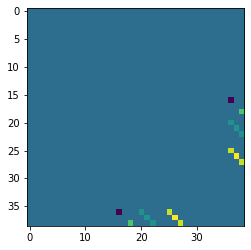

In [19]:
plt.imshow(H_laser_z.real)

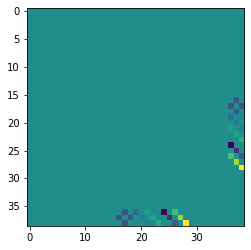

In [20]:
plt.imshow(H_laser_x.real)

In [21]:
# Calculate the matrix element for the "main" transition so that coupling matrix can be scaled to have appropriate rabi rate

# Define approximate form of main ground state
ground_main_approx = 1*CoupledBasisState(J=2,F1=5/2,F=2,mF=0,I1=1/2,I2=1/2,electronic_state='X', P = 1, Omega = 0)
ground_main_i = find_state_idx_from_state(H_X_diag,ground_main_approx, QN_X_diag)
ground_main = QN_X_diag[ground_main_i]

# Define approximate form of main excited state
excited_main_approx = 1*CoupledBasisState(J = 1,F1=3/2,F=1,mF=0,I1=1/2,I2=1/2, electronic_state='B', P = -1, Omega = 1)
excited_main_i = find_state_idx_from_state(H_B_diag,excited_main_approx, QN_B_diag)
excited_main = QN_B_diag[excited_main_i]

ME_main = ED_ME_mixed_state(excited_main, ground_main, pol_vec = np.array([0,0,1]))

In [22]:
ME_main

(-0.39444661441301954+0j)

## Collapse Operators

In [23]:
Gamma = 1/100e-9 # 2*pi [Hz]

In [24]:
excited_test_approx = 1*CoupledBasisState(J = 1, F1=3/2, F=1, mF=0, I1=1/2, I2=1/2, electronic_state='B', P = -1, Omega = 1)
excited_test_i = find_state_idx_from_state(H_B_diag,excited_test_approx, QN_B_diag)
excited_test = QN_B_diag[excited_test_i]

ground_test_approx = 1*CoupledBasisState(J=0,F1=1/2,F=1,mF=0,I1=1/2,I2=1/2,electronic_state='X', P = 1, Omega = 0)
ground_test_i = find_state_idx_from_state(H_X_diag,ground_test_approx, QN_X_diag)
ground_test = QN_X_diag[ground_test_i]

BRs = calculate_BR(excited_test, ground_states)

In [25]:
C_array = collapse_matrices(QN, ground_states, excited_states, gamma = Gamma)
C_conj_array = np.einsum('ijk->ikj', C_array.conj())

## Density Matrix

In [26]:
# Define states that are populated initially
Js = [0,1,2]
states_pop_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
              for J  in Js
              for F1 in ni_range(np.abs(J-I_Tl),J+I_Tl+1)
              for F in ni_range(np.abs(F1-I_F),F1+I_F+1)
              for mF in ni_range(-F, F+1)
             ]

states_pop = []
for state in states_pop_approx:
    i = find_state_idx_from_state(H_X_diag,state, QN_X_diag)
    states_pop.append(QN_X_diag[i])
    
pops = np.ones(len(states_pop))/len(states_pop)

rho_ini = generate_density_matrix(QN,states_pop,pops)

In [27]:
import scipy.constants as cst

def boltzmann_distribution(rot_constant, temperature, J_list):
    init = np.zeros(len(J_list))
    Z = 0
    g = 1
    for J in J_list:
        g = 4*(2*J+1)
        Z += g*np.exp(-rot_constant*J*(J+1)*2*np.pi*cst.hbar/(temperature*cst.k))
    for idx, J in enumerate(J_list):
        g = 4*(2*J+1)
        init[idx] = g*np.exp(-rot_constant*J*(J+1)*2*np.pi*cst.hbar/(temperature*cst.k))/Z
    return init

In [28]:
B_0 = 6.68667*1e9 # Hz
T = 7
boltz_dist = boltzmann_distribution(B_0,T, np.arange(0,150,1))

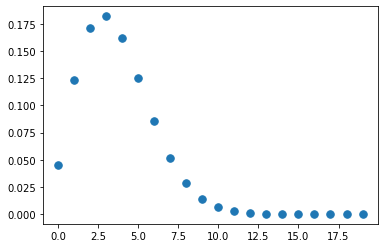

In [29]:
plt.plot(boltz_dist[:20], '.', ms = 15)

In [30]:
def get_J_indices(J_list):
    spans = []
    for J in J_list:
        spans.append(4*(2*J+1))
    indices = [(0,spans[0])]
    for idx,span in enumerate(spans[1:]):
        s = np.sum(spans[:idx+1])
        indices.append((s, s+span))
    return indices

In [31]:
for idx, (idx_min, idx_max) in enumerate(get_J_indices([0,1,2])):
    sl = np.s_[idx_min:idx_max, idx_min:idx_max]
    print(idx, idx_max-idx_min, boltz_dist[idx]/(idx_max-idx_min))
    np.fill_diagonal(rho_ini[sl], boltz_dist[idx]/(idx_max-idx_min))
rho_ini /= np.diag(rho_ini).sum()

0 4 0.011286978903789161
1 12 0.01029811954327005
2 20 0.008572714492675116


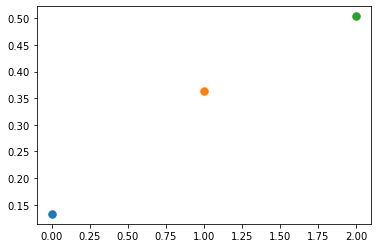

In [32]:
for idx, (idx_min, idx_max) in enumerate(get_J_indices([0,1,2])):
    sl = np.s_[idx_min:idx_max, idx_min:idx_max]
    plt.plot(idx, np.sum(np.diag(rho_ini[sl])).real, '.', ms = 15)

## Total Hamiltonian

In [33]:
def square_wave(t, frequency, phase = 0):
    return 0.5*(1+signal.square(2*np.pi*frequency*t+phase))

In [34]:
# Generate optical coupling matrix with set rabi rate
Omega = np.abs(4.5*Gamma*ME_main)

# Define frequency for polarization switching
omega_p = Gamma
wp = omega_p/(2*np.pi)

H_oc_t = lambda t: (Omega/ME_main/2)*(H_laser_z*square_wave(t, wp, 0) + H_laser_x*square_wave(t, wp, np.pi))

H_oc = Omega*H_laser_z/ME_main

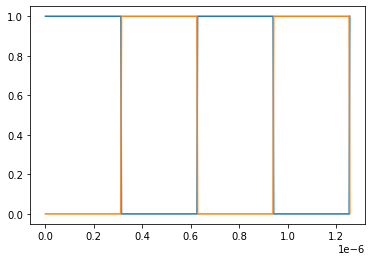

In [35]:
_t = np.linspace(0,2/wp, 501)
plt.plot(_t, square_wave(_t, wp, 0))
plt.plot(_t, square_wave(_t, wp, np.pi))

In [36]:
H_X_shifted = H_X_red - H_X_red[ground_main_i,ground_main_i]*np.eye(H_X_red.shape[0])

detuning = 0
H_B_shifted = np.diag(np.diag(H_B_red - H_B_diag[excited_main_i,excited_main_i] + detuning))

In [37]:
_H = np.zeros([39,39], dtype = 'complex')
_H[:36, :36] = H_X_shifted
_H[36:,36:] = H_B_shifted

def Hamiltonian(t):
    return _H + H_oc_t(t)

In [38]:
Cprecalc = np.einsum('ijk,ikl', C_conj_array, C_array)

## ODE Solver

In [39]:
#Define the rhs of the Lindblad equation
def Lindblad_rhs(t, rho_vec):
    dim = int(np.sqrt(len(rho_vec)))
    rho = rho_vec.reshape((dim,dim))
    
    _s = np.zeros(rho_ini.shape, dtype = 'complex')
    for idx in range(C_array.shape[0]):
        _s[:,:] += C_array[idx]@rho@C_conj_array[idx]
        
    rhs = (-1j* (Hamiltonian(t) @ rho - rho @ Hamiltonian(t)) + 
           _s
           -0.5 * (Cprecalc@rho + rho@Cprecalc)).flatten()
    return rhs

In [40]:
%%time
from scipy.integrate import solve_ivp

print(f'Ω = {np.abs(Omega/Gamma/ME_main):.1f}')

#Generate rho vector
rho_vec = rho_ini.flatten()

T = 100e-6

t_span = (0, T)

step_size = min(1/(Gamma/(2*np.pi))/10, 1/omega_p/10, 1/(Omega/(2*np.pi))/10)

print(f'step_size : {step_size:.2e}')

sol = solve_ivp(Lindblad_rhs, t_span, rho_vec, dense_output=True, max_step = step_size, vectorized = True)

Ω = 4.5
step_size : 1.00e-08
Wall time: 1min 15s


In [41]:
pop_results = np.real(np.einsum('jji->ji',sol.y.reshape((rho_ini.shape[0], rho_ini.shape[1], sol.y.shape[1]))))

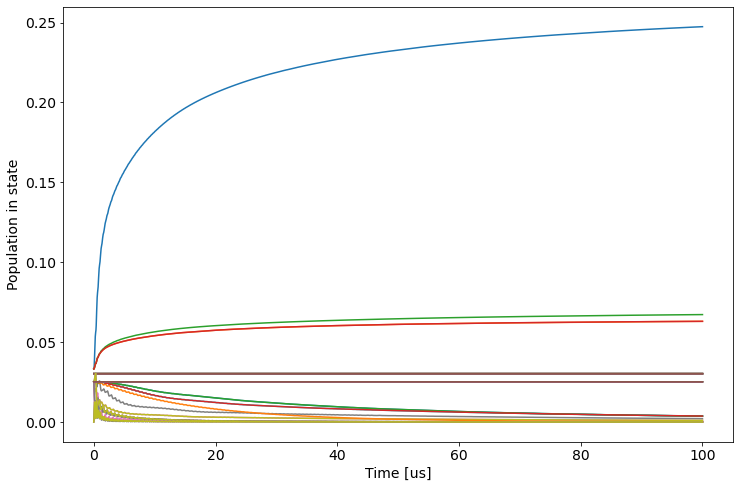

In [42]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(sol.t*1e6, pop_results.T)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)

3.3208437688215913


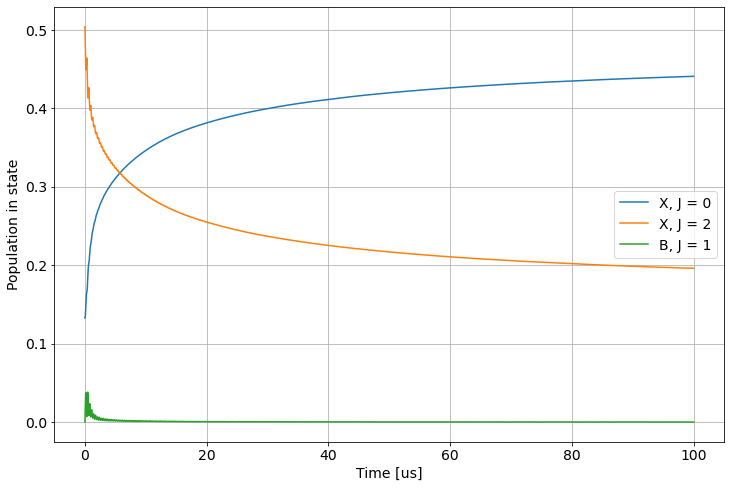

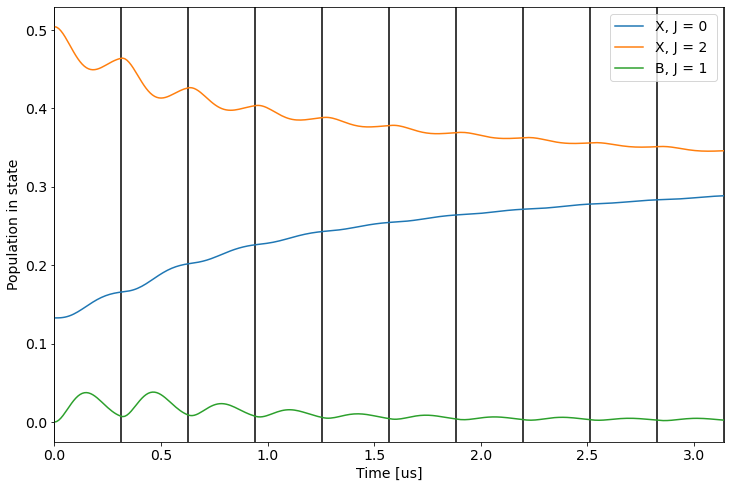

In [43]:
pop_results = np.real(np.einsum('jji->ji',sol.y.reshape((rho_ini.shape[0], rho_ini.shape[1], sol.y.shape[1]))))

t_array = sol.t

m = t_array <= 300e-6

t_array = t_array[m]
pop_results = pop_results[:,m]

#Plot populations in different J
P0_triplet = np.sum(pop_results[1:4,:], axis = 0)
P0_singlet = np.sum(pop_results[0:1,:], axis = 0)
P0 = np.sum(pop_results[:4], axis = 0)
P1 = np.sum(pop_results[4:16,:], axis = 0)
P2 = np.sum(pop_results[16:36,:], axis = 0)
PB1 = np.sum(pop_results[36:,:], axis = 0)

fig, ax = plt.subplots(figsize = (12,8))
# ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1')
# ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0')
ax.plot(t_array*1e6, P0, label = 'X, J = 0')
# ax.plot(t_array*1e6, P1, label = 'X, J = 1')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.grid(True)

fig, ax = plt.subplots(figsize = (12,8))
# ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1')
# ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0')
ax.plot(t_array*1e6, P0, label = 'X, J = 0')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1 ')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlim(0,5e6/wp)
for i in range(20):
    ax.axvline(i*1e6/wp/2, zorder = 0, color = 'k')

print(P0[-1]/P0[0])

## Julia with Python Function

In [44]:
import numba
import diffeqpy
import julia as jl
from diffeqpy import de

In [45]:
def Lindblad_rhs_julia(rho_vec, p, t):
    dim = int(np.sqrt(len(rho_vec)))
    rho = rho_vec.reshape((dim,dim))
    
    _s = np.zeros(rho_ini.shape, dtype = 'complex')
    for idx in range(C_array.shape[0]):
        _s[:,:] += C_array[idx]@rho@C_conj_array[idx]
        
    rhs = (-1j* (Hamiltonian(t) @ rho - rho @ Hamiltonian(t)) + 
           _s
           -0.5 * (Cprecalc@rho + rho@Cprecalc)).flatten()
    return rhs

In [46]:
prob = de.ODEProblem(Lindblad_rhs_julia, rho_vec, t_span)

First run compiles the problem

In [47]:
%%time
sol = de.solve(prob, saveat=5e-9)

Wall time: 1min 19s


Second run gives the the actual execution speed

In [48]:
%%time
sol = de.solve(prob, saveat=5e-9)

Wall time: 1min 11s


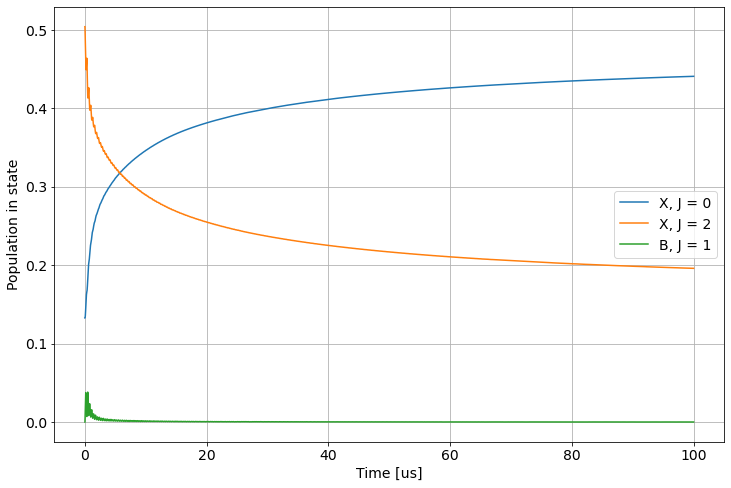

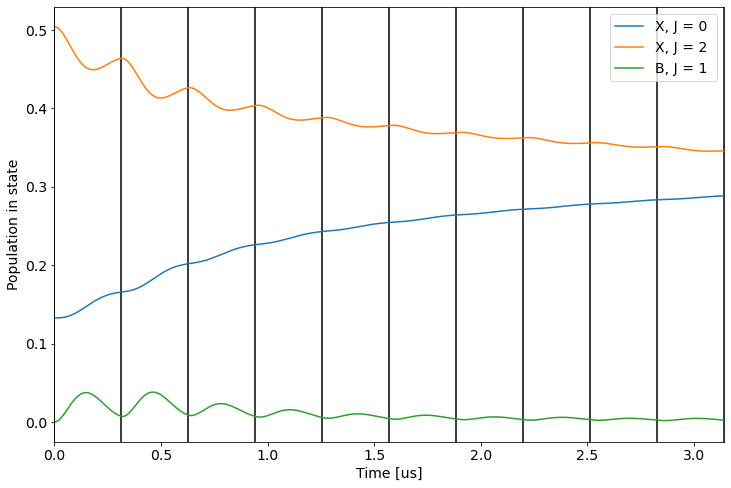

In [49]:
ut = np.transpose(sol.u)
pop_results = np.real(np.einsum('jji->ji',ut.reshape((rho_ini.shape[0], rho_ini.shape[1], ut.shape[1]))))
t_array = sol.t

m = t_array <= 300e-6

t_array = t_array[m]
pop_results = pop_results[:,m]

#Plot populations in different J
P0_triplet = np.sum(pop_results[1:4,:], axis = 0)
P0_singlet = np.sum(pop_results[0:1,:], axis = 0)
P0 = np.sum(pop_results[:4], axis = 0)
P1 = np.sum(pop_results[4:16,:], axis = 0)
P2 = np.sum(pop_results[16:36,:], axis = 0)
PB1 = np.sum(pop_results[36:,:], axis = 0)

fig, ax = plt.subplots(figsize = (12,8))
# ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1')
# ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0')
ax.plot(t_array*1e6, P0, label = 'X, J = 0')
# ax.plot(t_array*1e6, P1, label = 'X, J = 1')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.grid(True)

fig, ax = plt.subplots(figsize = (12,8))
# ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1')
# ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0')
ax.plot(t_array*1e6, P0, label = 'X, J = 0')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1 ')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlim(0,5e6/wp)
for i in range(20):
    ax.axvline(i*1e6/wp/2, zorder = 0, color = 'k')

### JIT compilation of Python functions

In [50]:
@numba.jit
def square_wave_jit(t, frequency, phase = 0):
    return 0.5*(1+signal.square(2*np.pi*frequency*t+phase))

In [51]:
@numba.jit
def H_oc_t_jit(t):
    return (Omega/ME_main/2)*(H_laser_z*square_wave_jit(t, wp, 0) + H_laser_x*square_wave_jit(t, wp, np.pi))

In [52]:
_H = np.zeros([39,39], dtype = 'complex')
_H[:36, :36] = H_X_shifted
_H[36:,36:] = H_B_shifted

@numba.jit
def Hamiltonian_jit(t):
    return _H + H_oc_t_jit(t)

In [53]:
@numba.jit
def Lindblad_rhs_jit(rho_vec, p, t):
    dim = int(np.sqrt(len(rho_vec)))
    rho = rho_vec.reshape((dim,dim))
    
    _s = np.zeros(rho_ini.shape, dtype = 'complex')
    for idx in range(C_array.shape[0]):
        _s[:,:] += C_array[idx]@rho@C_conj_array[idx]
        
    rhs = (-1j* (Hamiltonian_jit(t) @ rho - rho @ Hamiltonian_jit(t)) + 
           _s
           -0.5 * (Cprecalc@rho + rho@Cprecalc)).flatten()
    return rhs

In [54]:
prob = de.ODEProblem(Lindblad_rhs_jit, rho_vec, t_span)

In [55]:
%%time
sol = de.solve(prob, saveat=1e-8)

<ipython-input-53-1f83e79b6581>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "Lindblad_rhs_jit" failed type inference due to: non-precise type pyobject
During: typing of argument at <ipython-input-53-1f83e79b6581> (3)

File "<ipython-input-53-1f83e79b6581>", line 3:
def Lindblad_rhs_jit(rho_vec, p, t):
    dim = int(np.sqrt(len(rho_vec)))
    ^

  @numba.jit
<ipython-input-53-1f83e79b6581>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "Lindblad_rhs_jit" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-53-1f83e79b6581>", line 7:
def Lindblad_rhs_jit(rho_vec, p, t):
    <source elided>
    _s = np.zeros(rho_ini.shape, dtype = 'complex')
    for idx in range(C_array.shape[0]):
    ^

  @numba.jit
C:\Users\Olivier\Anaconda3\lib\site-packages\numba\core\object_mode_passes.py:177: NumbaWarning: Funct

Wall time: 1min 23s


In [56]:
%%time
sol = de.solve(prob, saveat=1e-8)

Wall time: 1min 25s


3.320811961301347


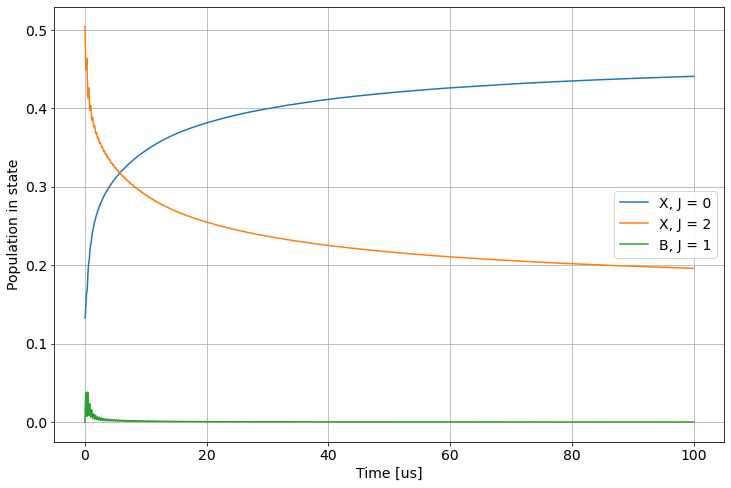

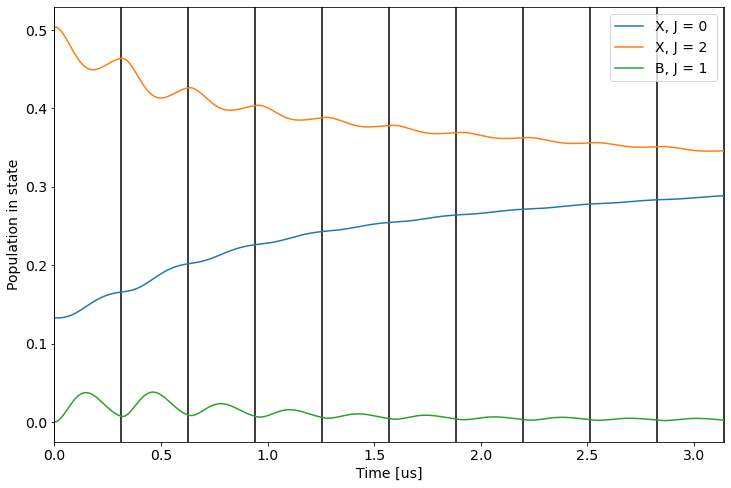

In [57]:
ut = np.transpose(sol.u)
pop_results = np.real(np.einsum('jji->ji',ut.reshape((rho_ini.shape[0], rho_ini.shape[1], ut.shape[1]))))
t_array = sol.t

m = t_array <= 300e-6

t_array = t_array[m]
pop_results = pop_results[:,m]

#Plot populations in different J
P0_triplet = np.sum(pop_results[1:4,:], axis = 0)
P0_singlet = np.sum(pop_results[0:1,:], axis = 0)
P0 = np.sum(pop_results[:4], axis = 0)
P1 = np.sum(pop_results[4:16,:], axis = 0)
P2 = np.sum(pop_results[16:36,:], axis = 0)
PB1 = np.sum(pop_results[36:,:], axis = 0)

fig, ax = plt.subplots(figsize = (12,8))
# ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1')
# ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0')
ax.plot(t_array*1e6, P0, label = 'X, J = 0')
# ax.plot(t_array*1e6, P1, label = 'X, J = 1')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.grid(True)

fig, ax = plt.subplots(figsize = (12,8))
# ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1')
# ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0')
ax.plot(t_array*1e6, P0, label = 'X, J = 0')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1 ')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlim(0,5e6/wp)
for i in range(20):
    ax.axvline(i*1e6/wp/2, zorder = 0, color = 'k')
    
print(P0[-1]/P0[0])

## Julia Function 

In [58]:
import julia as jl
from julia import Main

In [59]:
jl.Main.eval("""using Waveforms""")
jl.Main.eval("""using DifferentialEquations""")
jl.Main.eval("""using StaticArrays""")
jl.Main.eval("""using LinearAlgebra""")

In [60]:
Main.C_array = C_array
Main.C_conj_array = C_conj_array
Main.H_laser_z = H_laser_z
Main.H_laser_x = H_laser_x
Main.ME_main = ME_main
Main.Omega = Omega
Main.wp = wp
Main.Cprecalc = Cprecalc
Main.rho_ini = rho_ini
Main.Hprecalc = _H

In [61]:
jl.Main.eval("""
const C_array_const = C_array
const C_conj_array_const = C_conj_array
""");

In [62]:
jl.Main.eval("""
const H_laser_z_const = H_laser_z
const H_laser_x_const = H_laser_x
const Cprecalc_const = Cprecalc
const Hprecalc_const = Hprecalc
const wp_const = wp
const ME_main_const = ME_main
const Omega_const = Omega
""")

17750097.64858588

In [63]:
jl.Main.eval("""
function square_wave(t::Float64, frequency::Float64, phase::Float64)
    0.5.*(1 .+ squarewave(2*pi.*frequency.*t .+ phase))
end
""")

<PyCall.jlwrap square_wave>

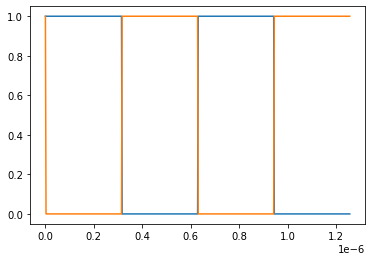

In [64]:
_t = np.linspace(0,2/wp, 501)
plt.plot(_t, [Main.square_wave(ti, wp, 0.0) for ti in _t])
plt.plot(_t, [Main.square_wave(ti, wp, np.pi) for ti in _t])

In [65]:
jl.Main.eval("""
function H_oc_t(t::Float64)
    (Omega_const./ME_main_const)./2 .* (H_laser_z_const.*square_wave(t,wp_const,0.0) .+ H_laser_x_const.*square_wave(t,wp_const,3.141592653589793))
end
""")

<PyCall.jlwrap H_oc_t>

In [66]:
jl.Main.eval("""
function Hamiltonian(t::Float64)
    Hprecalc_const .+ H_oc_t(t)
end
""")

<PyCall.jlwrap Hamiltonian>

In [67]:
jl.Main.eval("""
function sum_mult!(result::Array{Complex{Float64},2}, 
                  A::Array{Complex{Float64},3},
                  B::Array{Complex{Float64},2}, 
                  C::Array{Complex{Float64},3},
                  idx_max::Int64,
                  shape::Array{Int64,1}
    )
    intermediate1 = zeros(ComplexF64, shape[1], shape[2])
    intermediate2 = zeros(ComplexF64, shape[1], shape[2])
    @inbounds for i = 1:idx_max
        mul!(intermediate1,B,C[i,:,:])
        mul!(intermediate2, A[i,:,:], intermediate1)
        result .+= intermediate2
    end
end
""")

<PyCall.jlwrap sum_mult!>

In [68]:
jl.Main.eval("""
function Lindblad_rhs!(du::Array{Complex{Float64}}, u::Array{Complex{Float64},2}, p, t::Float64)
    intermediate = zeros(ComplexF64,39,39)
    fill!(du,0.0)
    sum_mult!(du,C_array_const,u,C_conj_array_const,33,[39,39])
    mul!(intermediate, Hamiltonian(t), u)
    du .-= 1im .* intermediate
    mul!(intermediate, u, Hamiltonian(t))
    du .+= 1im .* intermediate
    mul!(intermediate, Cprecalc_const, u)
    du .-= 0.5 .* intermediate
    mul!(intermediate, u, Cprecalc_const)
    du .-= 0.5 .* intermediate
end
""")

<PyCall.jlwrap Lindblad_rhs!>

In [69]:
%%time
jl.Main.eval("""
tspan = (0.0f0, 100e-6)
prob = ODEProblem(Lindblad_rhs!,rho_ini,tspan)
sol = solve(prob)
tmp = 0
""")

Wall time: 2min 11s


0

In [70]:
%%time
jl.Main.eval("""
tspan = (0.0f0, 100e-6)
prob = ODEProblem(Lindblad_rhs!,rho_ini,tspan)
sol = solve(prob, Tsit5())
tmp = 0
""")

Wall time: 20.4 s


0

3.3214663443461974


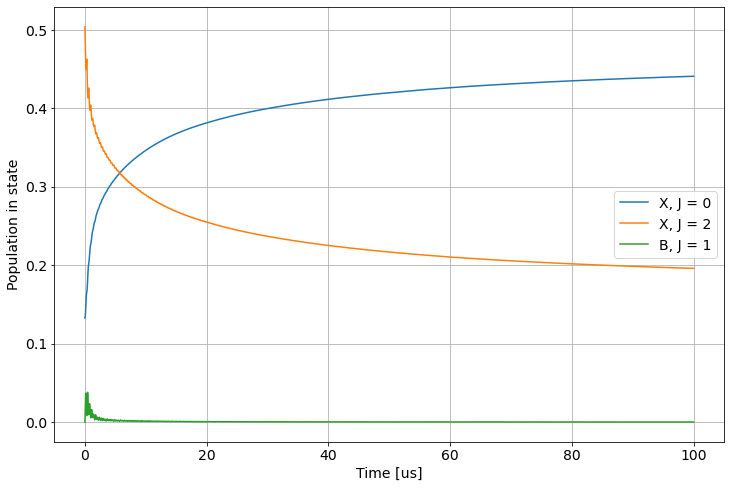

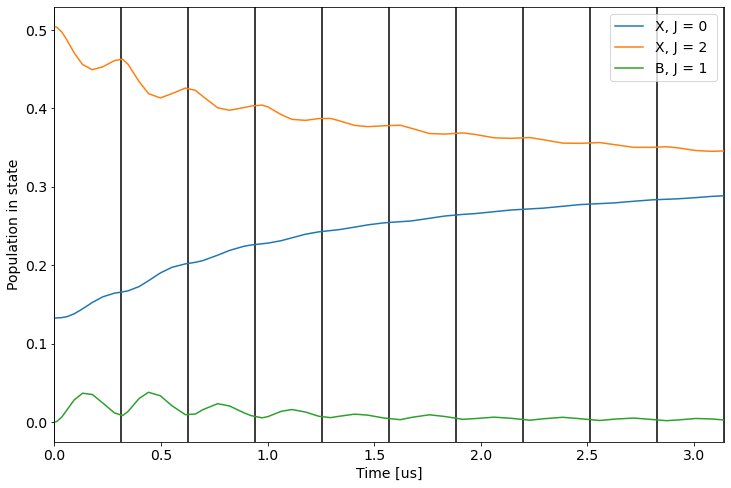

In [71]:
ut = np.array(jl.Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((rho_ini.shape[0], rho_ini.shape[1], ut.shape[2]))))
t_array = jl.Main.eval("""sol.t""")

m = t_array <= 300e-6

t_array = t_array[m]
pop_results = pop_results[:,m]

#Plot populations in different J
P0_triplet = np.sum(pop_results[1:4,:], axis = 0)
P0_singlet = np.sum(pop_results[0:1,:], axis = 0)
P0 = np.sum(pop_results[:4], axis = 0)
P1 = np.sum(pop_results[4:16,:], axis = 0)
P2 = np.sum(pop_results[16:36,:], axis = 0)
PB1 = np.sum(pop_results[36:,:], axis = 0)

fig, ax = plt.subplots(figsize = (12,8))
# ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1')
# ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0')
ax.plot(t_array*1e6, P0, label = 'X, J = 0')
# ax.plot(t_array*1e6, P1, label = 'X, J = 1')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.grid(True)

fig, ax = plt.subplots(figsize = (12,8))
# ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1')
# ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0')
ax.plot(t_array*1e6, P0, label = 'X, J = 0')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1 ')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlim(0,5e6/wp)
for i in range(20):
    ax.axvline(i*1e6/wp/2, zorder = 0, color = 'k')
    
print(P0[-1]/P0[0])

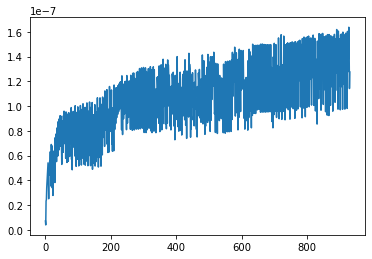

In [72]:
plt.plot(np.diff(t_array))

In [73]:
jl.Main.eval("""
function H_oc_t(t::Float64, Omega::Float64, wp::Float64)
    (Omega./ME_main_const)./2 .* (H_laser_z_const.*square_wave(t,wp,0.0) .+ H_laser_x_const.*square_wave(t,wp,3.141592653589793))
end
""")

<PyCall.jlwrap H_oc_t>

In [74]:
jl.Main.eval("""
function Hamiltonian(t::Float64, Omega::Float64, wp::Float64)
    Hprecalc_const .+ H_oc_t(t,Omega, wp)
end
""")

<PyCall.jlwrap Hamiltonian>

In [75]:
jl.Main.eval("""
function Lindblad_rhs!(du::Array{Complex{Float64}}, u::Array{Complex{Float64},2}, p::Array{Float64}, t::Float64)
    Omega = p[1]
    wp = p[2]
    
    intermediate = zeros(ComplexF64,39,39)
    fill!(du,0.0)
    sum_mult!(du,C_array_const,u,C_conj_array_const,33,[39,39])
    Ham = Hamiltonian(t, Omega, wp)
    mul!(intermediate, Ham, u)
    du .-= 1im .* intermediate
    mul!(intermediate, u, Ham)
    du .+= 1im .* intermediate
    mul!(intermediate, Cprecalc_const, u)
    du .-= 0.5 .* intermediate
    mul!(intermediate, u, Cprecalc_const)
    du .-= 0.5 .* intermediate
end
""")

<PyCall.jlwrap Lindblad_rhs!>

In [76]:
Main.eval("p = [Omega, wp]")

array([17750097.64858588,  1591549.43091895])

In [135]:
%%time
jl.Main.eval("""
tspan = (0.0f0, 100e-6)
prob = ODEProblem(Lindblad_rhs!,rho_ini,tspan,p)
sol = solve(prob, Tsit5(), saveat = 5e-8)
tmp = 0
""")

Wall time: 23.7 s


0

In [136]:
Main.eval("Threads.nthreads()")

8

In [137]:
Main.eval("const Omegas = (Omega/4.5)*(0.5:0.25:4.5)")

[1972233.0720650975,
 2958349.6080976464,
 3944466.144130195,
 4930582.680162744,
 5916699.216195293,
 6902815.752227841,
 7888932.28826039,
 8875048.82429294,
 9861165.360325487,
 10847281.896358036,
 11833398.432390586,
 12819514.968423134,
 13805631.504455682,
 14791748.040488232,
 15777864.57652078,
 16763981.112553328,
 17750097.64858588]

In [138]:
jl.Main.eval("""
function prob_func(prob,i,repeat)
    remake(prob,p=[Omegas[i],wp])
end
""")

<PyCall.jlwrap prob_func>

In [139]:
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func)
""")

<PyCall.jlwrap EnsembleProblem with problem ODEProblem>

In [145]:
%%time
Main.eval("""
sim = solve(ens_prob, ensemblealg=EnsembleThreads(), trajectories=2, saveat = 5e-8)
tmp = 0
""")

Wall time: 4min 59s


0

In [146]:
ens_u = Main.eval("sim.u")

2.5637314953551464
2.994714262371648


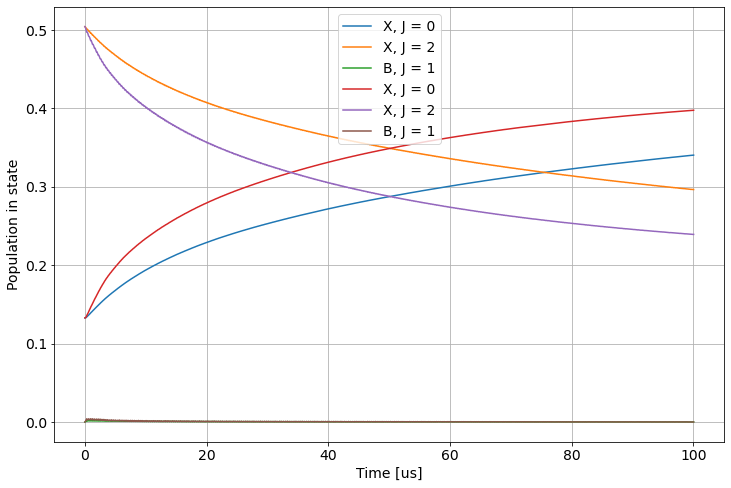

In [147]:
fig, ax = plt.subplots(figsize = (12,8))
    
for ut_ens in ens_u:
    ut_ens = np.array(ut_ens)
    pop_results = np.real(np.einsum('jji->ji',ut_ens.reshape((rho_ini.shape[0], rho_ini.shape[1], ut_ens.shape[2]))))
    t_array = np.linspace(0, ut_ens.shape[2]-1,  ut_ens.shape[2])*5e-8

    m = t_array <= 1e9

    t_array = t_array[m]
    pop_results = pop_results[:,m]

    #Plot populations in different J
    P0_triplet = np.sum(pop_results[1:4,:], axis = 0)
    P0_singlet = np.sum(pop_results[0:1,:], axis = 0)
    P0 = np.sum(pop_results[:4], axis = 0)
    P1 = np.sum(pop_results[4:16,:], axis = 0)
    P2 = np.sum(pop_results[16:36,:], axis = 0)
    PB1 = np.sum(pop_results[36:,:], axis = 0)

    # ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1')
    # ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0')
    ax.plot(t_array*1e6, P0, label = 'X, J = 0')
    # ax.plot(t_array*1e6, P1, label = 'X, J = 1')
    ax.plot(t_array*1e6, P2, label = 'X, J = 2')
    ax.plot(t_array*1e6, PB1, label = 'B, J = 1')

    print(P0[-1]/P0[0])
    
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.grid(True)